# <h1><center><span style="color:red">Avis Restau : Topic Modeling and Image Classification</span></center></h1>

In [1]:
#basic libraries
import pandas as pd
import numpy as np
import os
import shutil
import pathlib
import json

from pprint import pprint
import texttable

#plotting
import seaborn as sns
import plotly.express as px
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import string
from nltk.corpus import stopwords
import json
import glob
import re

In [3]:
#text preprocessing
import re
from langdetect import detect_langs
import nltk

# For the Stop Words
from nltk.corpus import stopwords

import spacy
from spacy.language import Language
nlp = spacy.load("en_core_web_sm", disable = ["tok2vec","parser", "tagger","attribute_ruler"])
# Disabling components not needed
nlp.add_pipe("merge_noun_chunks")
nlp.add_pipe("merge_entities")
nlp.add_pipe("sentencizer")
lemmatizer = nlp.get_pipe("lemmatizer")
#analysis = nlp.analyze_pipes(pretty=True)

In [4]:
#image preprocessing
import cv2

# load and show an image with Pillow
import PIL
from PIL import Image
from IPython.display import display # to display images

In [5]:
# Machine learning

# Convert the Words into Count Vectpr 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

#visualisation in 2D
from sklearn.manifold import TSNE
from sklearn import manifold, decomposition
from sklearn import cluster, metrics

#LDA
import gensim
from gensim.models import Word2Vec
from gensim.corpora import Dictionary

from yellowbrick.cluster import kelbow_visualizer,  SilhouetteVisualizer

from wordcloud import WordCloud

# LDA Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models

from sklearn.cluster import MiniBatchKMeans
from sklearn import svm
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.metrics import accuracy_score,classification_report,plot_confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [6]:
#yelp API
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
from configparser import ConfigParser
config = ConfigParser()

In [7]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# <h1><center>Section I : Finding  topics in dissatisfied reviews</center></h1>

### Step 1 : Loading relevent data
**select 200 restaurants' reviews for our analysis**

In [8]:
#get the output fold path
inputWD = os. getcwd()+"\\yelp_dataset\\"
selected_reviews_file = "df_resto_random_reviews.csv"

if os.path.exists(selected_reviews_file) is False:
    ################import reviews file ###############
    rev_file = "yelp_academic_dataset_review.json"
    review=[]
    with open(inputWD + rev_file) as fl:
        for i, line in enumerate(fl):
            review.append(json.loads(line))
            if i+1 >= 100000:
                break
    df_review = pd.DataFrame(review)
    
    biz_file = "yelp_academic_dataset_business.json"
    biz=[]
    with open(inputWD + biz_file) as fl:
        for i, line in enumerate(fl):
            biz.append(json.loads(line))
            if i+1 >= 10000:
                break
    df_business = pd.DataFrame(biz)

    ################pick up randomly reviews for 200 restaurants ###############
    #get the list of ids for restaurants
    mask = df_business['categories'].str.contains('Restaurants')  
    df_business[mask == True]
    ids = df_business.business_id.unique()
    #select 200
    idx = np.random.randint(len(ids), size=200)
    random_ids= ids[idx].tolist()
    #save the result
    reviews = df_review.query("business_id==@random_ids")
    reviews = reviews.merge(df_business[['business_id','name']], on='business_id',how='left')
    reviews = reviews.drop(columns = ['user_id','review_id','useful','funny','cool'])
    reviews.to_csv(selected_reviews_file, index=False)
else:
    #load selected data
    reviews = pd.read_csv(selected_reviews_file)


reviews['date'] = pd.to_datetime(reviews['date'], errors='coerce')
reviews["date"]= pd.to_datetime(reviews["date"]).dt.date
#df.set_index('date').head(1)
print ("the shape of reviews:", reviews.shape)
reviews.info()

the shape of reviews: (1342, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1342 entries, 0 to 1341
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   business_id  1342 non-null   object 
 1   stars        1342 non-null   float64
 2   text         1342 non-null   object 
 3   date         1342 non-null   object 
 4   name         1342 non-null   object 
dtypes: float64(1), object(4)
memory usage: 52.5+ KB


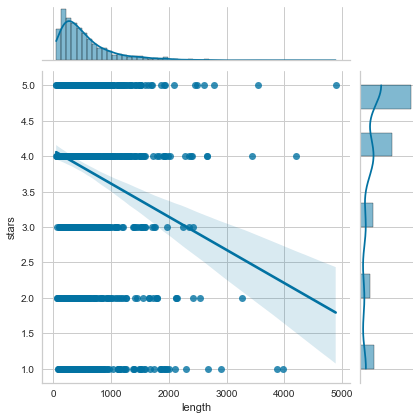

In [9]:
reviews["length"] = reviews["text"].apply(len)

sns.jointplot(x="length",
              y="stars",
              data=reviews, kind='reg')

It Looks like as length of text  Increases the Rating is decreasing

In [10]:
df_restos = reviews.groupby('name').agg({'stars':'mean','business_id':'count'}).sort_values("business_id",ascending=False).rename(columns={'business_id': 'number'})
df_restos[:10]

,stars,number
name,,
South Congress Cafe,4.040541,370
Pelons Tex-Mex,3.562500,80
Breakfast At Valerie's,3.953846,65
Miller's Ale House - Orlando,3.190476,63
Ramen Danbo,4.081633,49
Sage Woodfire Tavern Perimeter,3.173913,46
Luck Bros Coffee House,4.702703,37
Eurasia Sushi Bar & Seafood,4.481481,27
Bulla Gastrobar,4.560000,25


**Now let's take one for analysis. Most of them are about the restaurant South Congress Cafe, so we'll pick up this one as our case study.**

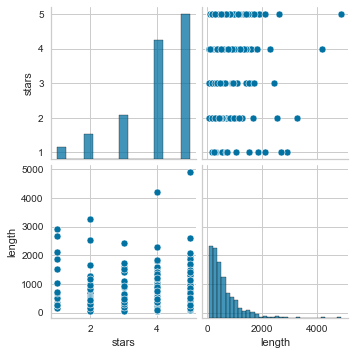

In [11]:
#filter on this restaurant
resto_name = df_restos.index[0]
df_resto = reviews.query("name==@resto_name")
#plotting
sns.pairplot(df_resto)

Text(0.5, 1.0, 'numbers of review over years')

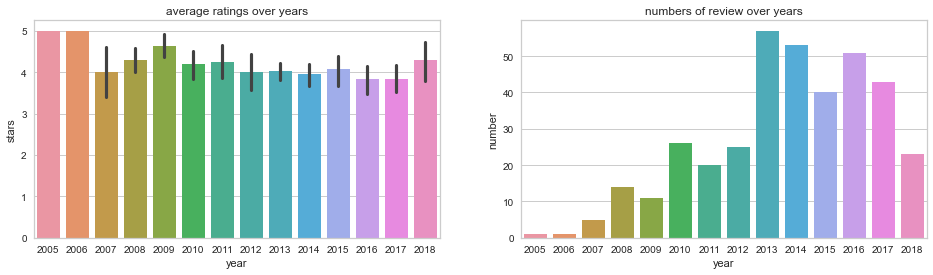

In [12]:

#add month and year columns
df_resto["year"] = pd.to_datetime(df_resto["date"]).dt.year
df_resto["month"] = pd.to_datetime(df_resto["date"]).dt.month


fig, ax = plt.subplots()
fig.set_size_inches(16,4)

#plotting by month
plt.subplot(1,2,1)
sns.barplot(x="year", y="stars", data=df_resto)
plt.title("average ratings over years")#plotting by year
plt.subplot(1,2,2)
sns.barplot(x='year', y="number", data=df_resto.groupby('year').agg({'stars':'count'}).rename(columns={'stars': 'number'}).reset_index())
plt.title("numbers of review over years")


The restaurant seems to be gaining in popularity in the early 2010s seeing as the increase number of reviews.

In [13]:
df = df_resto.query("stars<=3")
print ("%d bad reviews out of %d reivews for %s." % (df.shape[0], df_resto.shape[0], resto_name))

87 bad reviews out of 370 reivews for South Congress Cafe.


### Step 2 : Text checking
**Check if all the disssatisfactions are expressed in english**
- It looks like there's just one review which is written in spain, so we exclude this one out of our list.

In [14]:
language = [detect_langs(i) for i in df['text']]
df['language'] = [str(i[0]).split(':')[0] for i in language]

In [15]:
for lang in df['language'].unique(): 
    print(len(df.query("language==@lang")), 'reviews are written in {}.'.format(lang))

87 reviews are written in en.


In [16]:
df = df.query("language=='en'")

**Walk thought all reviews quickly to check if there's format or other issues**

In [17]:
# concatenate all the reviews into one single string 
full_text = ' '.join(df['text'])
number_of_words = len(full_text.split())
print('total words:',number_of_words)
print(full_text[:1000],"...")

total words: 12612
I recently took two of my D.C. buddies here to "experience" Austin. Why did I do this? Because up until my last visit there, which happened to be on a Friday morning, I have always enjoyed this restaurant. Their food is very good, and that is the only reason I have left them 2 stars. However, their hostess actually ignored me for a good 30 seconds when I walked in because she was playing 'read my lips' with someone across the room. As a customer, I found this to be disrespectful. Then she tried to seat us next to the kitchen- when I pointed to an available table on the other side of the room, she got pissy. At this point I was just embarrassed that this restaurant was going to be my guest's first impression of Austin. The drinks are overpriced and plain. I won't be going back, South Congress Cafe has become absurdly busy and pretentious...maybe South Congress in general has just lost its charm. My best friend was in town and we decided to try this cafe because there 

**Here’s what we could see:**

- There are no obvious typos or spelling mistakes, so we are not going to standardize spelling, which can be very long.
- there's ni markup nor accent
- there's no section marker
- there hours (like 6:30) and monetary signs (like $)
- there websites, Email Addresses
- There’s punctuation like commas, apostrophes, quotes, question marks, and more.


### Step 3 : Tokenization
- Remove URLs, Email addresses
- Convert to lowercase
- Filter out tokens that are stop words
- Split into tokens with chunks
- Remove punctuation from each token
- Filter out remaining tokens that are not alphabetic
- Reduce each word to its base form.

In [18]:
def text_cleaner(text):
    text1 = re.sub(r'[.\w]{3,}@[.\w]{5,}', '', text) #emails
    text2 = re.sub(r'www.[.\w]{3,}', '', text1) #websites
    text3 = re.sub(r'https?://[.\w]{3,}', '', text2) #urls
    text4 = re.sub(r'[\d\s\W]{7,}', '', text3) #phones

    return text4


df['clean_text'] = [text_cleaner(text) for text in df.text]

In [19]:
#get the list of stop words
   
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(['i\'ve','i\'m','get','got','would','could','n\'t','go','went'])

- Tokenization using the natural language toolkit library

In [20]:
def tokenize_with_nltk(text):
    
    #TweetTokenizer keeps hashtags and apostrophies intact while word_tokenize doesn't.
    tokens= nltk.word_tokenize(text)
    chunked = nltk.ne_chunk(nltk.pos_tag(tokens))
    
    #initialization
    prev = None
    continuous_chunk = []
    current_chunk = []

    for i in chunked:
        #chunk
        if type(i) == nltk.Tree:
            current_chunk.append(" ".join([token for token, pos in i.leaves()]))
            named_entity = " ".join(current_chunk)
            continuous_chunk.append(named_entity)
            current_chunk = []
        #other words
        else:
            word = i[0].lower()
            #get rid of stop words on lowercase string, punctuaions and numbers
            if len(word)>2 and (word not in stop_words) and word[0].isalpha():
                #lemmatization                
                lemma = nltk.wordnet.WordNetLemmatizer()
                lemmatized = lemma.lemmatize(word, 'v')
                continuous_chunk.append(lemmatized)
            else:
                continue

    return continuous_chunk

In [21]:
%%time
tokens_nltk = [tokenize_with_nltk(text) for text in df.clean_text]

Wall time: 5.71 s


In [22]:
print(color.BOLD +"First tokenized phrase:"+ color.END, tokens_nltk[0])

First tokenized phrase: ['recently', 'take', 'two', 'd.c.', 'buddies', 'experience', 'Austin', 'last', 'visit', 'happen', 'friday', 'morning', 'always', 'enjoy', 'restaurant', 'food', 'good', 'reason', 'leave', 'star', 'however', 'host', 'actually', 'ignore', 'good', 'second', 'walk', 'play', 'lips', 'someone', 'across', 'room', 'customer', 'find', 'disrespectful', 'try', 'seat', 'next', 'kitchen-', 'point', 'available', 'table', 'side', 'room', 'pissy', 'point', 'embarrass', 'restaurant', 'go', 'guest', 'first', 'impression', 'Austin', 'drink', 'overprice', 'plain', 'go', 'back', 'South', 'Congress Cafe', 'become', 'absurdly', 'busy', 'pretentious', 'maybe', 'South', 'Congress', 'general', 'lose', 'charm']


- Tokenization using the spaCy library

In [23]:
def tokenize_with_spacy(text):
    
    #  "nlp" Object is used to create documents with linguistic annotations.
    doc = nlp(text)
    
    tokens=[]
    for token in doc:
        # Including some of the conditions as no punctuations, no space, no digital, no currency, no stop words 
        if token.text[0].isalpha() and not token.is_stop:
            #lemmatize or plural to singular
            lemm = token.lemma_
            #add lemmatized token
            tokens.append(lemm)
    
    return tokens

In [24]:
%%time
tokens_nlp = [tokenize_with_spacy(text) for text in df.clean_text]

Wall time: 1.06 s


In [25]:
print(color.BOLD +"First tokenized phrase:"+ color.END, tokens_nlp[0])

First tokenized phrase: ['recently', 'took', 'd.c.', 'buddies', 'experience', 'austin', 'visit', 'happened', 'friday', 'morning', 'enjoyed', 'restaurant', 'food', 'good', 'reason', 'left', 'stars', 'hostess', 'actually', 'ignored', 'a good 30 seconds', 'walked', 'playing', 'read', 'lips', 'room', 'customer', 'found', 'disrespectful', 'tried', 'seat', 'kitchen-', 'pointed', 'available', 'table', 'room', 'got', 'pissy', 'point', 'embarrassed', 'restaurant', 'going', 'guest', 'impression', 'austin', 'drinks', 'overpriced', 'plain', 'wo', 'going', 'south congress cafe', 'absurdly', 'busy', 'pretentious', 'maybe', 'south congress', 'general', 'lost', 'charm']


**Analyse of the results of two tokenization methods for the first phrase**

In [26]:
print("- words in nltk but not in spacy", list(set(tokens_nltk[0]) - set(tokens_nlp[0])))

- words in nltk but not in spacy ['always', 'star', 'Austin', 'embarrass', 'try', 'play', 'overprice', 'ignore', 'become', 'find', 'Congress', 'go', 'South', 'lose', 'however', 'Congress Cafe', 'last', 'walk', 'drink', 'second', 'take', 'side', 'someone', 'leave', 'across', 'two', 'back', 'first', 'enjoy', 'host', 'happen', 'next']


In [27]:
print("- words in sapcy but not in nltk", list(set(tokens_nlp[0]) - set(tokens_nltk[0])))

- words in sapcy but not in nltk ['playing', 'hostess', 'walked', 'overpriced', 'south congress', 'pointed', 'lost', 'got', 'found', 'austin', 'enjoyed', 'stars', 'took', 'happened', 'read', 'embarrassed', 'wo', 'going', 'left', 'ignored', 'a good 30 seconds', 'south congress cafe', 'drinks', 'tried']


It seems like that SpaCy is faster while nltk is slower, even though spacy don't covert the singularization of nouns, but it took out more commun words like 'much', 'less', 'one'..., so it seems that a mix of them would be a better fit for our topics modeling.

In [28]:
tokens = [tokenize_with_nltk(' '.join(tokenize_with_spacy(text))) for text in df.clean_text]
descriptions = [' '.join(text) for text in tokens]

In [29]:
print(color.BOLD + 'The final words that retained from the first review:' + color.END, tokens[0])
print('total tokens:',len(sum(tokens,[])))

The final words that retained from the first review: ['recently', 'take', 'd.c.', 'buddies', 'experience', 'austin', 'visit', 'happen', 'friday', 'morning', 'enjoy', 'restaurant', 'food', 'good', 'reason', 'leave', 'star', 'host', 'actually', 'ignore', 'good', 'second', 'walk', 'play', 'read', 'lips', 'room', 'customer', 'find', 'disrespectful', 'try', 'seat', 'kitchen-', 'point', 'available', 'table', 'room', 'pissy', 'point', 'embarrass', 'restaurant', 'go', 'guest', 'impression', 'austin', 'drink', 'overprice', 'plain', 'go', 'south', 'congress', 'cafe', 'absurdly', 'busy', 'pretentious', 'maybe', 'south', 'congress', 'general', 'lose', 'charm']
total tokens: 4970


**Word cloud**
- The more a specific word appears in the text, the bigger and bolder it will be in the word cloud

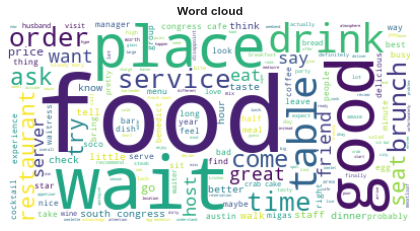

In [30]:
# création de la fenêtre graphique 
plt.figure(figsize=(16,6))

#word cloud
plt.subplot(1,2,1)
cloud_words = WordCloud(background_color='white').generate(" ".join(descriptions))
plt.imshow(cloud_words, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud',fontweight="bold", fontsize=12)
plt.show()

**Analyse the words frequency**

In [31]:
def words_frequency(tokens):
    #ignore all words that have appeared in 85% of the documents
    vectorizer=CountVectorizer(max_df=0.85)

    #generate the words_vector
    corpus = [' '.join(token) for token in tokens]
    bow = vectorizer.fit_transform(corpus)

    #calculate the frequency
    sum_words = bow.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    return words_freq

In [32]:
words_freq = words_frequency(tokens)

print('retained unique words:',len(dict(words_freq).keys()))

retained unique words: 1443


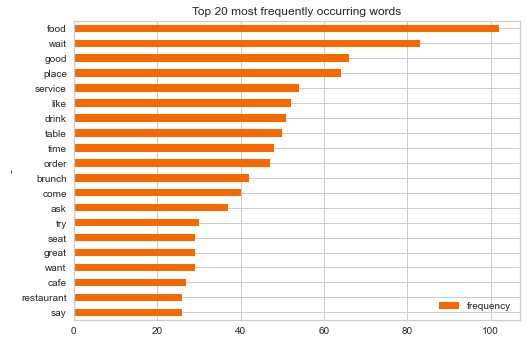

In [33]:
#plot words
df_words = pd.DataFrame(words_freq, columns = ['-', 'frequency']).set_index('-')
df_words[:20].plot(kind='barh', 
                   color="#f56900", 
                   title='Top 20 most frequently occurring words').invert_yaxis()

**Bigrams** 
- Using pairs of words that appear next to each other in order to better capture the context.

In [34]:
#get the bigrams
def bigrams_frequency(tokens):
    #Using count vectoriser to view the frequency of bigrams
    bvectorizer = CountVectorizer(ngram_range=(2, 2))
    
     #generate the words_vector
    corpus = [' '.join(token) for token in tokens]
    bigrams = bvectorizer.fit_transform(corpus)

    #calculate the frequency
    sum_bigrams = bigrams.sum(axis=0)
    bigrams_freq = [(word, sum_bigrams[0, idx]) for word, idx in bvectorizer.vocabulary_.items()]
    bigrams_freq =sorted(bigrams_freq, key = lambda x: x[1], reverse=True)
    
    return bigrams_freq

In [35]:
bigrams_freq = bigrams_frequency(tokens)
print('total bigrams:',len(dict(bigrams_freq).keys()))

total bigrams: 4356


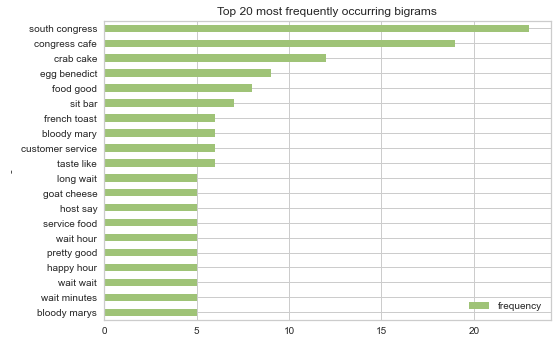

In [36]:
#plot bigrams
df_bigrams = pd.DataFrame(bigrams_freq, columns = ['-', 'frequency']).set_index('-')
df_bigrams[:20].plot(kind='barh', 
           color="g", 
           title='Top 20 most frequently occurring bigrams').invert_yaxis()

- A little bit of words embedding to get a better sense of these words

In [37]:
def sentencize(text):

    # split the long string into sentences
    sentences = [str(sent).strip() for sent in nlp(text).sents]

    # get tokens for each sentence
    sent_tokens = list()
    for sentence in sentences:
        sent_tokens.append(tokenize_with_nltk(' '.join(tokenize_with_spacy(sentence))))
        
    return sent_tokens


sentences=sentencize(' '.join(df.clean_text))

In [38]:
model_2vec = Word2Vec(sentences=sentences, 
                 vector_size=1000, 
                 window=5, #5 words before and after the target
                 min_count=2, 
                 workers=4, 
                 sg=1 #skip-gram=1,CWOB=0
                )

1. get a better sense of customer-service

In [39]:
print("The most relevent words (with similarity score) to customer-service are :")
similar_words = model_2vec.wv.most_similar(positive=['customer','service'],topn=10)
similar_words

The most relevent words (with similarity score) to customer-service are :


[('food', 0.9466162323951721),
 ('wait', 0.9412321448326111),
 ('drink', 0.9395725131034851),
 ('like', 0.9343560338020325),
 ('take', 0.9325699806213379),
 ('cafe', 0.9304937124252319),
 ('ask', 0.9235355854034424),
 ('table', 0.9232072830200195),
 ('congress', 0.9217003583908081),
 ('good', 0.921075701713562)]

### Step 4 : Targeted TF-IDF Topic modeling
1. Create tf-idf vectorizer

In [40]:
vectorizer = TfidfVectorizer(  lowercase=True,
                                max_features=100,
                                max_df=0.85,
                                min_df=2,
                                ngram_range = (2,3),
                                stop_words = "english"

                            )
vectors = vectorizer.fit_transform(descriptions)

2. extract the key words

In [41]:
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()

all_keywords = []

for description in denselist:
    x=0
    keywords = []
    for word in description:
        if word > 0:
            keywords.append(feature_names[x])
        x=x+1
    all_keywords.append(keywords)
    
print (color.BOLD + 'cleaned phrase:' + color.END, descriptions[0])
print (color.BOLD + 'extracted key words:'+ color.END, all_keywords[0])

cleaned phrase: recently take d.c. buddies experience austin visit happen friday morning enjoy restaurant food good reason leave star host actually ignore good second walk play read lips room customer find disrespectful try seat kitchen- point available table room pissy point embarrass restaurant go guest impression austin drink overprice plain go south congress cafe absurdly busy pretentious maybe south congress general lose charm
extracted key words: ['congress cafe', 'food good', 'south congress', 'south congress cafe']


3. clustering

In [42]:
true_k = 5
model = KMeans(n_clusters=true_k, init="k-means++", max_iter=1000, n_init=1)
model.fit(vectors)

KMeans(max_iter=1000, n_clusters=5, n_init=1)

In [43]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(true_k):
    ind = order_centroids[i, :5]
    kw = ','.join(np.array(terms)[ind])
    # Display table
    print('Topic '+str(i+1),':', kw, '\n'+'_'*127)

Topic 1 : egg benedict,crab cake,good service,service good,sit bar 
_______________________________________________________________________________________________________________________________
Topic 2 : south congress,congress cafe,south congress cafe,want try,host say 
_______________________________________________________________________________________________________________________________
Topic 3 : goat cheese bacon,cheese bacon,goat cheese,place star,worth wait 
_______________________________________________________________________________________________________________________________
Topic 4 : pretty good,food good,rave review,overall experience,bloody mary 
_______________________________________________________________________________________________________________________________
Topic 5 : worth wait,hour half,wait wait,wait hour,friend like 
______________________________________________________________________________________________________________________________

4. plotting

In [44]:
#create tsne dataframe
w_tnse = TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
w_projected = w_tnse.fit_transform(vectors.toarray())

df_2vec = pd.DataFrame(w_projected[:,0:2], columns=['tsne1','tsne2'], index=df.year)
df_2vec['topic'] = model.predict(vectors)+1

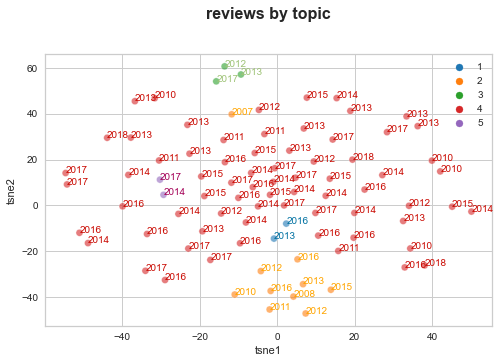

In [47]:
plt.figure(figsize=(8,5))

palette_tab10 = sns.color_palette('tab10', n_colors=true_k)

sns.scatterplot(x="tsne1", y="tsne2", hue='topic', data=df_2vec, legend="brief",
    palette=palette_tab10, 
                s=50, 
                alpha=0.6)

plt.title('reviews by topic', fontsize = 16, pad = 35, fontweight = 'bold')
plt.legend(prop={'size': 10}) 

#by color
for k in range(0,true_k):
    df_annot = df_2vec.query('topic==@k+1')
    c = ['b','orange','g','r','m'][k]
    #annotation
    for line in range(0,df_annot.shape[0]):
         plt.text(df_annot.tsne1.tolist()[line]+0.01, df_annot.tsne2.tolist()[line], 
         df_annot.index.tolist()[line], horizontalalignment='left', 
         size='small', color=c, weight='ultralight')
plt.show()

# <h1><center>Section II : Image classification</center></h1>

## Prep step : Setting training/test databsets
**To train the model, let's randomly pick up 200 images from each class and copy them to the directory named by the class.**

In [48]:
df_photos = []
with open(inputWD + "photos.json", "r") as f:
    reader = pd.read_json(f, orient="records", lines=True, 
                          chunksize=1000)
        
    for chunk in reader:
        reduced_chunk = chunk.drop(columns=['business_id','caption'])
        df_photos.append(reduced_chunk)
    
df_photos = pd.concat(df_photos, ignore_index=True)

In [49]:
train_path = inputWD + "photo_sample\\"
df_photos_sample_file="df_photo_samples.csv"


#select randomly a certain number of pictures from each classe
if os.path.isdir(train_path) is False:
    df_sample = pd.DataFrame()
    label_names = df_photos.label.unique().tolist()
    n_train = 200
    n_test=6

    for l in label_names:
        #select photos
        df_temp = df_photos.query("label==@l").sample(n=n_train+n_test,  random_state=1)
        #----------------------select photos for training-------------
        df = df_temp[:n_train]
        # For each of the classes make a folder to contain them
        os.makedirs(inputWD + "photo_sample\\" + l )
        #copy images
        for image_name in df.photo_id:
            original =  inputWD + "photos\\" + image_name + '.jpg'
            target = inputWD + "photo_sample\\" + l + "\\" + image_name + '.jpg'
            shutil.copyfile(original, target)
        #build df
        df_sample = pd.concat([df_sample, df], axis=0)
        #----------------------select photos for test-------------
        df_test = df_temp[n_train:]
        os.makedirs(inputWD + "photo_test\\" + l )
        #copy images
        for image_name in df_test.photo_id:
            original =  inputWD + "photos\\" + image_name + '.jpg'
            target = inputWD + "photo_test\\" + l + "\\" + image_name + '.jpg'
            shutil.copyfile(original, target)

    df_sample.to_csv(df_photos_sample_file, index=False)
else:
    df_sample = pd.read_csv(df_photos_sample_file)

class_names: ['drink', 'food', 'interior', 'menu', 'outside']
total training photos: 1000


<AxesSubplot:>

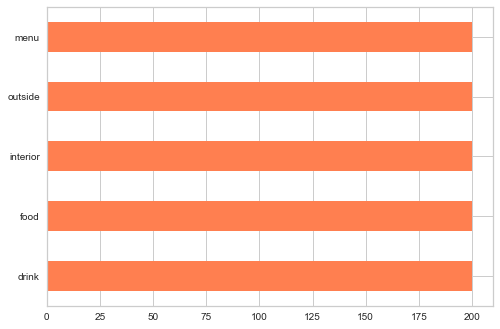

In [50]:
class_names=os.listdir(train_path)
print("class_names:",class_names)
print("total training photos:", df_sample.shape[0])
df_sample.label.value_counts().plot(kind='barh', color='coral')

## SIFT Features extraction approach with Support Vector Machine (SVM) classifier
### Step 1 : Set training and testing datasets

In [51]:
#List all the filenames in the directory
data=df_sample.copy()
data['img_path'] = [train_path + l + '\\' for l in data.label]
data['img_name'] = [img + '.jpg' for img in data.photo_id]
data['img_list'] = data['img_path'] + data['img_name']
data = data[['img_list', 'label']]

# shuffle the rows of a dataframe 
data = data.iloc[np.random.permutation(len(data))]


#traing/test set
X_train, X_test, y_train, y_test = train_test_split(data['img_list'],data['label'],test_size=0.2)

### Step 2 : Creating the Bag of Visual Features(BoVF)
1. Denoising and equalizing histograms

In [52]:
def img_preprocess(img):
    """
    read, denoise and equalization the historogram
    """
    
    #---------read image
    img = cv2.imread(img)
    
    #----------downsize image
    scale_percent = 0.4 # percent of original size
    width = int(img.shape[1] * scale_percent)
    height = int(img.shape[0] * scale_percent)
    dim = (width, height)

    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    
    #-----------remove noise from color images
    img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
    
    #------------------histogram equalization
    # convert image from RGB to HSV
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # Histogram equalisation on the V-channel
    img_hsv[:, :, 2] = cv2.equalizeHist(img_hsv[:, :, 2])
    # convert image back from HSV to RGB
    img_output = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)
    
    return img_output

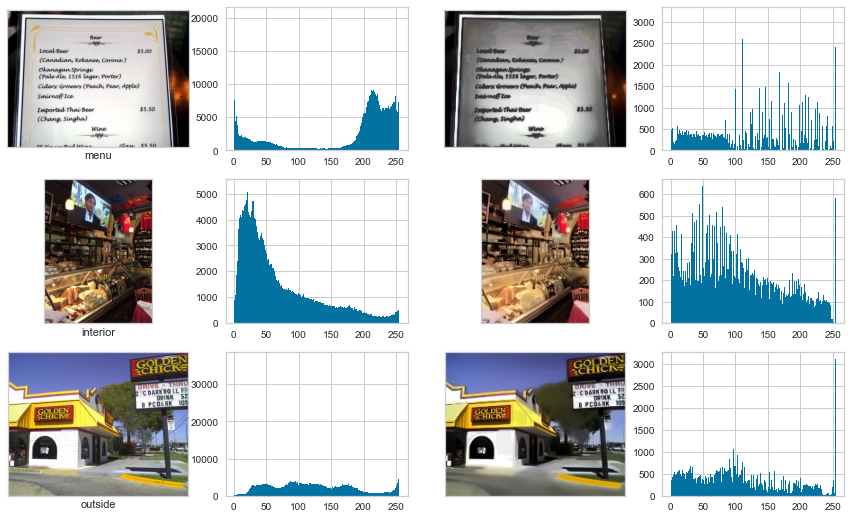

Wall time: 4.36 s


In [53]:
%%time
plt.figure(figsize=(15, 9))

for i in range(3):
    #plot the image
    plt.subplot(3, 4, i*4 + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(y_train.values[i])
    org_img =  Image.open(X_train.values[i])
    plt.imshow(org_img)
    #plot the histogramm by his side
    plt.subplot(3, 4, i*4 + 2)
    n, bins, patches = plt.hist(np.asarray(org_img).flatten(), bins=range(256))
    #plot the denoising
    plt.subplot(3, 4, i*4 + 3)
    prep_img = img_preprocess(X_train.values[i])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(prep_img)
    #plot the histogramm by his side
    plt.subplot(3, 4, i*4 + 4)
    n, bins, patches = plt.hist(np.asarray(prep_img).flatten(), bins=range(256))

plt.show()

2. scale-invariant feature transform (SIFT)

In [54]:
def sift_detect(img):
    """"
    generate SIFT keypoints and descriptors
    # kp is the keypoints
    # descriptor is the SIFT descriptors, they're 128-dimensional vectors
    """
    #convert to gray
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #sift method
    sift = cv2.xfeatures2d.SIFT_create()
    kp, descriptor = sift.detectAndCompute(gray_img, None)

    return kp, descriptor

Wall time: 1.81 s


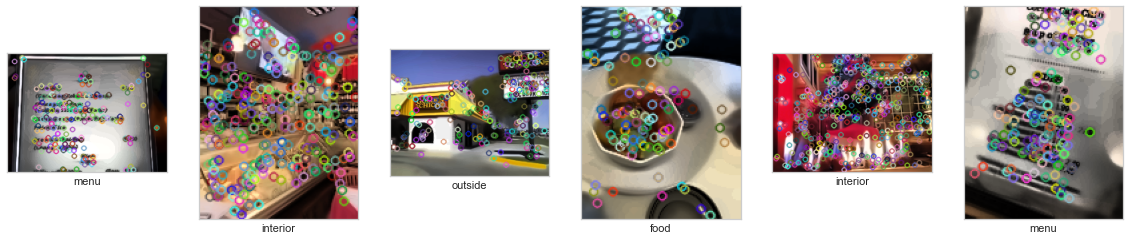

In [55]:
%%time
plt.figure(figsize=(20, 4))

for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(y_train.values[i])
    prep_img = img_preprocess(X_train.values[i])
    kp, desc = sift_detect(prep_img)
    plt.imshow(cv2.drawKeypoints(prep_img, kp, prep_img.copy()))

In [56]:
def extractFeatures(img_list):
    descriptors = {}
 
    for i in range(0, len(img_list)):
        img = img_preprocess(img_list[i])
        kp, desc = sift_detect(img)
        if type(desc) != type(None):
            descriptors[i] = desc
        
    return descriptors

In [57]:
%%time
dict_desc = extractFeatures(X_train.values)

Wall time: 3min 11s


In [58]:
def groupAllFeatures(dict_descriptors):
    list_descriptors = []    
    for i, desc in dict_descriptors.items():
            list_descriptors.extend(desc)
            
    return list_descriptors

In [59]:
list_desc = groupAllFeatures(dict_desc)

4. clustering with k (sqrt)

In [60]:
def trainKMeans(list_descriptors, k):

    batch_size = int(len(list_descriptors) / 3) 
    
    kmeans = MiniBatchKMeans(n_clusters = k,
                             batch_size = batch_size,
                             verbose = 0).fit(list_descriptors)
    
    return kmeans

In [61]:
%%time
k = int(round(np.sqrt(len(list_desc)),0))
kmeans = trainKMeans(list_desc, k)

Wall time: 52.7 s


5. Creation of the histograms of features

In [62]:
def generateHistograms(dict_descriptors):
    
    histograms = []
    
    for i, desc in dict_descriptors.items(): 
        #kmeans works only on float, so convert integers to float
        preds = kmeans.predict(desc.astype(float))
        hist, bin_edges = np.histogram(a = preds,
                                       bins = range(0, k))
        histograms.append(hist)
    
    return histograms

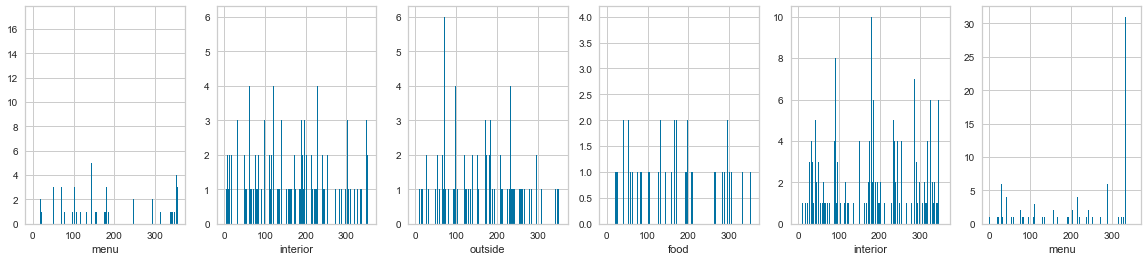

In [63]:
plt.figure(figsize=(20, 4))

n=6
f = extractFeatures(X_train.values[:n])
histo = generateHistograms(f)

for i in range(n):
    plt.subplot(1, n, i+1)
    plt.xlabel(y_train.values[i])
    plt.bar([i for i in range(len(histo[i]))],histo[i])

In [64]:
im_features = np.asarray(generateHistograms(dict_desc))

6. dimensions reduction with PCA

In [65]:
print("Dimensions dataset before PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset after PCA : ", feat_pca.shape)

Dimensions dataset before PCA :  (800, 356)
Dimensions dataset after PCA :  (800, 310)


In [66]:
#create tsne dataframe
tsne_feat = TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne_feat.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
#add label
df_tsne['class'] = y_train.to_list()

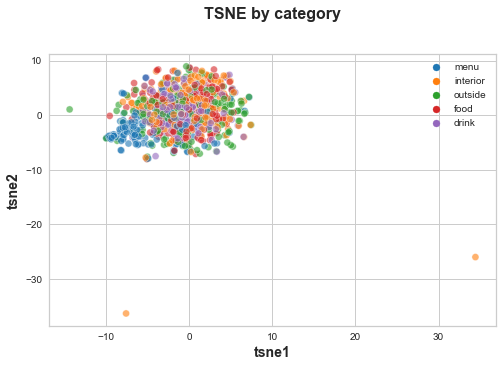

In [67]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=5), 
                s=50, 
                alpha=0.6)

plt.title('TSNE by category', fontsize = 16, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 14, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 14, fontweight = 'bold')
plt.legend(prop={'size': 10}) 

plt.show()

7. Training SVM classifier

In [68]:
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)
model = svm.SVC()
X=feat_pca
y=y_train
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('cross validation accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

cross validation accuracy: 0.520 (0.029)


In [69]:
%%time
model.fit(X,y)

Wall time: 113 ms


SVC()

8. plotting similarities between classes et clusters

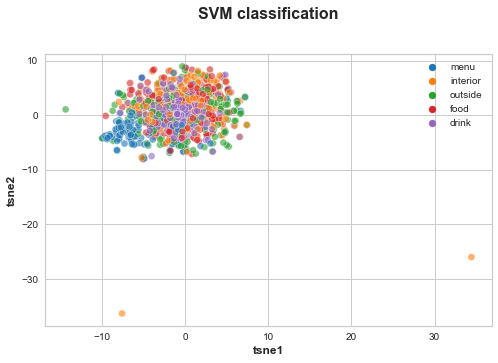

In [70]:
#plotting
plt.figure(figsize=(8,5))

#get predicted clusters
df_tsne["cluster"] = model.predict(X)

sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('SVM classification', fontsize = 16, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 12, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 12, fontweight = 'bold')
plt.legend(prop={'size': 10}) 

plt.show()

9. generating features for test images

In [71]:
def global_features(img_list):
    
    feature_vec = []

    # Get Features
    desc = extractFeatures(img_list)

    # Get Histograms
    histograms = np.asarray(generateHistograms(desc))
    
    pca_features = pca.transform(histograms)
    
    feature_vec.extend(pca_features)    
    
    return feature_vec

In [72]:
%%time
test_feat= global_features(X_test.values)

Wall time: 44.9 s


Text(0.5, 1.0, 'Test images')

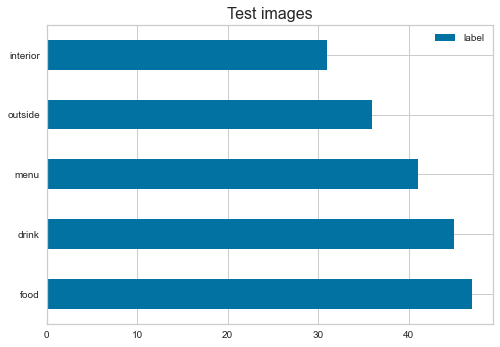

In [73]:
pd.DataFrame(y_test.value_counts()).plot(kind='barh')
plt.title("Test images", fontsize=16)

In [74]:
SVM_predict = model.predict(test_feat)
print('Test score: %.2f\n' % (accuracy_score(y_test, SVM_predict)))
# Classification report for Classifier
print("Classification report for Classifier: \n\n%s: \n\n %s" % (model,
                                                                 classification_report(y_test,
                                                                                       SVM_predict)))

Test score: 0.52

Classification report for Classifier: 

SVC(): 

               precision    recall  f1-score   support

       drink       0.44      0.67      0.53        45
        food       0.69      0.47      0.56        47
    interior       0.29      0.39      0.33        31
        menu       0.83      0.61      0.70        41
     outside       0.50      0.39      0.44        36

    accuracy                           0.52       200
   macro avg       0.55      0.50      0.51       200
weighted avg       0.57      0.52      0.52       200



<AxesSubplot:>

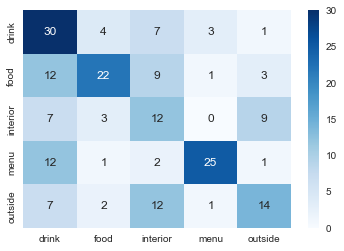

In [75]:
#generate a confusion matrix
conf_mat = metrics.confusion_matrix(y_test, SVM_predict)
df_cm = pd.DataFrame(conf_mat, index = [label for label in class_names],
                  columns = [label for label in class_names])

#plotting
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

# <h1><center>Section III : Scraping data using Yelp GraphQL API </center></h1>

In [76]:
#get api key
config.read(inputWD + 'keys_config.cfg')
api_key = config.get('yelp', 'api_key')

# define our authentication process.
header = {'Authorization':'Bearer {}'.format(api_key),
          'Content-Type':"application/json"}

# Build the request framework
transport = RequestsHTTPTransport(url="https://api.yelp.com/v3/graphql", headers=header, use_json=True)

# Create the client
client = Client(transport=transport, fetch_schema_from_transport=True)


In [77]:
api_file = 'Yelp_api_200_resto_reviews.csv'

if os.path.exists(api_file) is False:
    #initiate
    df_reviews=pd.DataFrame()
    
    ################pick up randomly 200 restaurants ###############
    biz_file = "yelp_academic_dataset_business.json"
    biz=[]
    with open(inputWD + biz_file) as fl:
        for i, line in enumerate(fl):
            biz.append(json.loads(line))
            if i+1 >= 10000:
                break
    df_business = pd.DataFrame(biz)


    #get the list of ids for restaurants
    mask = df_business['categories'].str.contains('Restaurants')  
    df_business[mask == True]
    ids = df_business.business_id.unique()
    #select 200
    idx = np.random.randint(len(ids), size=200)
    random_ids= ids[idx].tolist()

    ################build queries###############
    for i in range(len(random_ids)):
        #get info for one restaurant
        biz = random_ids[i]
        # define the query
        query = '''
        {
          reviews(business: "%s") {
            review {
                rating
                text
            }
          }
        }
        ''' % (biz)
    
        response = client.execute(gql(query))

        #remove review level from the response
        response['reviews']=response['reviews']['review']
        dict_of_df = {k: pd.DataFrame(v) for k,v in response.items()}
        df = pd.concat(dict_of_df, axis=1)
        #drop top level column index reviews
        df.columns = df.columns.droplevel()
        #add business_id
        df = df.assign(business_id=biz)
        df_reviews = df_reviews.append(df, ignore_index = True)

    #put business_id before rating
    cols = df_reviews.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df_reviews = df_reviews[cols]
    df_reviews.to_csv(api_file,index=False)
else:
    df_reviews = pd.read_csv(api_file)

In [78]:
print("reviews of 200 restaurants from yelp API:")
df_reviews

reviews of 200 restaurants from yelp API:


,business_id,rating,text
0,yx3Ab0V39RlFJ7iPC9WlXg,4,Located just two blocks from the Texas State C...
1,yx3Ab0V39RlFJ7iPC9WlXg,5,I visit Lavazza at least every other week. The...
2,yx3Ab0V39RlFJ7iPC9WlXg,2,Drink=4 stars.\n\nCustomer service= 1.5-2 star...
3,O4e7y6zOqBGZX4sIWJk0Gg,5,Saw this place while vacationing in Vancouver....
4,O4e7y6zOqBGZX4sIWJk0Gg,4,"Dim Sum arrived hot, fresh and fast. Service w..."
...,...,...,...
595,OIHN-nJzVOKn12zO45EKtw,5,I called Pristine just yesterday and Andy was ...
596,OIHN-nJzVOKn12zO45EKtw,5,My car had been through toddler hell. Just pic...
597,-5QHSKcivs71MHcD1ASBSg,5,Moving from the Midwest to Oregon was a challe...
598,-5QHSKcivs71MHcD1ASBSg,1,TLDR: Kershaw & Associates cost us just over $...
